### 我们要实现的最终功能是可以查询各个城市间的路线，先来看看我们拥有的数据

In [1]:
#geoCoord中第一个是经度longitude，第二个是纬度latitude
coordination_source = """
{name:'兰州', geoCoord:[103.73, 36.03]},
{name:'嘉峪关', geoCoord:[98.17, 39.47]},
{name:'西宁', geoCoord:[101.74, 36.56]},
{name:'成都', geoCoord:[104.06, 30.67]},
{name:'石家庄', geoCoord:[114.48, 38.03]},
{name:'拉萨', geoCoord:[102.73, 25.04]},
{name:'贵阳', geoCoord:[106.71, 26.57]},
{name:'武汉', geoCoord:[114.31, 30.52]},
{name:'郑州', geoCoord:[113.65, 34.76]},
{name:'济南', geoCoord:[117, 36.65]},
{name:'南京', geoCoord:[118.78, 32.04]},
{name:'合肥', geoCoord:[117.27, 31.86]},
{name:'杭州', geoCoord:[120.19, 30.26]},
{name:'南昌', geoCoord:[115.89, 28.68]},
{name:'福州', geoCoord:[119.3, 26.08]},
{name:'广州', geoCoord:[113.23, 23.16]},
{name:'长沙', geoCoord:[113, 28.21]},
//{name:'海口', geoCoord:[110.35, 20.02]},
{name:'沈阳', geoCoord:[123.38, 41.8]},
{name:'长春', geoCoord:[125.35, 43.88]},
{name:'哈尔滨', geoCoord:[126.63, 45.75]},
{name:'太原', geoCoord:[112.53, 37.87]},
{name:'西安', geoCoord:[108.95, 34.27]},
//{name:'台湾', geoCoord:[121.30, 25.03]},
{name:'北京', geoCoord:[116.46, 39.92]},
{name:'上海', geoCoord:[121.48, 31.22]},
{name:'重庆', geoCoord:[106.54, 29.59]},
{name:'天津', geoCoord:[117.2, 39.13]},
{name:'呼和浩特', geoCoord:[111.65, 40.82]},
{name:'南宁', geoCoord:[108.33, 22.84]},
//{name:'西藏', geoCoord:[91.11, 29.97]},
{name:'银川', geoCoord:[106.27, 38.47]},
{name:'乌鲁木齐', geoCoord:[87.68, 43.77]},
{name:'香港', geoCoord:[114.17, 22.28]},
{name:'澳门', geoCoord:[113.54, 22.19]}
"""

### 那第一步就是要从上面这一长串字符串中把我们要用的数据提取出来。这里我们用正则表达式来提取信息

In [24]:
import re 
line='{name:\'兰州\', geoCoord:[103.73, 36.03]}，name:\'测试\''
test=re.findall("name:'(\w+)'",line)

In [25]:
test

['兰州', '测试']

In [26]:
test[0]

'兰州'

In [12]:
#输入字符串，返回字典
def get_city_info(city_coordination):
    city_location = {}
    #逐行提取，遇到特定行跳过
    for line in city_coordination.split("\n"):    
        if line.startswith("//"): continue
        if line.strip() == "":continue
        #提取出城市名和坐标，最后以字典形式返回    
        city = re.findall("name:'(\w+)'",line)[0]
        x_y = re.findall("Coord:\[(\d+.\d+),\s(\d+.\d+)\]",line)[0]
        x_y = tuple(map(float,x_y))
        city_location[city] = x_y
    return city_location

In [13]:
city_info = get_city_info(coordination_source)

In [14]:
city_info

{'兰州': (103.73, 36.03),
 '嘉峪关': (98.17, 39.47),
 '西宁': (101.74, 36.56),
 '成都': (104.06, 30.67),
 '石家庄': (114.48, 38.03),
 '拉萨': (102.73, 25.04),
 '贵阳': (106.71, 26.57),
 '武汉': (114.31, 30.52),
 '郑州': (113.65, 34.76),
 '济南': (117.0, 36.65),
 '南京': (118.78, 32.04),
 '合肥': (117.27, 31.86),
 '杭州': (120.19, 30.26),
 '南昌': (115.89, 28.68),
 '福州': (119.3, 26.08),
 '广州': (113.23, 23.16),
 '长沙': (113.0, 28.21),
 '沈阳': (123.38, 41.8),
 '长春': (125.35, 43.88),
 '哈尔滨': (126.63, 45.75),
 '太原': (112.53, 37.87),
 '西安': (108.95, 34.27),
 '北京': (116.46, 39.92),
 '上海': (121.48, 31.22),
 '重庆': (106.54, 29.59),
 '天津': (117.2, 39.13),
 '呼和浩特': (111.65, 40.82),
 '南宁': (108.33, 22.84),
 '银川': (106.27, 38.47),
 '乌鲁木齐': (87.68, 43.77),
 '香港': (114.17, 22.28),
 '澳门': (113.54, 22.19)}

### 第二步我们希望把各个城市按照其经纬度嵌入到二维平面上

首先我们来看下如何计算经纬度之间的距离，下面是计算haversine distance的函数

In [27]:
import math
#输入两组坐标，返回坐标之间的haversine distance。
def geo_distance(origin, destination):
    #注：老师课上的代码是把lat放在第一位，lon放在第二位。事实上国外的习惯包括谷歌地图的确是把lat放在第一位。
    #但是我们的输入数据是按照经度纬度的顺序，所以我改下了下面的顺序后续的图也都不一样。
    lon1, lat1 = origin
    lon2, lat2 = destination
    #地球半径6371km
    radius = 6371  
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [28]:
#试试效果吧
def get_city_distance(city1,city2):
    return geo_distance(city_info[city1],city_info[city2])

get_city_distance("杭州","上海")

163.0760821403945

In [37]:
get_city_distance("嘉峪关","乌鲁木齐")

993.3968683460413

##### 接下来是作图

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
#确保图上能显示出中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [30]:
#这些就是我们希望画在图上的节点
city_info.keys()

dict_keys(['兰州', '嘉峪关', '西宁', '成都', '石家庄', '拉萨', '贵阳', '武汉', '郑州', '济南', '南京', '合肥', '杭州', '南昌', '福州', '广州', '长沙', '沈阳', '长春', '哈尔滨', '太原', '西安', '北京', '上海', '重庆', '天津', '呼和浩特', '南宁', '银川', '乌鲁木齐', '香港', '澳门'])

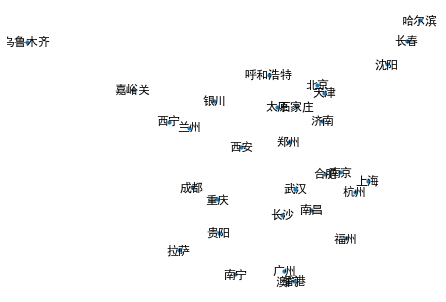

In [31]:
city_graph = nx.Graph()
city_graph.add_nodes_from(list(city_info.keys()))
nx.draw(city_graph, city_info, with_labels=True, node_size=10)

### 第三步，我们把城市间的路线描绘出来

这里我们假定，城市间距离小于700km即为可达，这里就对不起乌鲁木齐了因为嘉峪关距离乌鲁木齐993.3968683460413km

In [44]:
threshold = 700

In [45]:
#defaultdict的特性是，若字典中不存在指定key则返回默认值
from collections import defaultdict

In [46]:
#输入包含城市经纬度信息的字典，返回包含城市路径的字典（类似图的邻接表）
def build_connection(city_info):
    cities_connection = defaultdict(list)
    cities = list(city_info.keys())
    for c1 in cities:
        for c2 in cities:
            if c1 == c2 : continue
            #若两个城市距离小于threshold，则存在通路
            if get_city_distance(c1,c2) < threshold:
                cities_connection[c1].append(c2)
    return cities_connection

cities_connection = build_connection(city_info)

In [47]:
cities_connection

defaultdict(list,
            {'兰州': ['嘉峪关', '西宁', '成都', '西安', '银川'],
             '嘉峪关': ['兰州', '西宁'],
             '西宁': ['兰州', '嘉峪关', '成都', '银川'],
             '成都': ['兰州', '西宁', '拉萨', '贵阳', '西安', '重庆'],
             '石家庄': ['郑州', '济南', '太原', '西安', '北京', '天津', '呼和浩特'],
             '拉萨': ['成都', '贵阳', '重庆', '南宁'],
             '贵阳': ['成都', '拉萨', '长沙', '重庆', '南宁'],
             '武汉': ['郑州', '南京', '合肥', '杭州', '南昌', '福州', '长沙', '西安', '上海'],
             '郑州': ['石家庄',
              '武汉',
              '济南',
              '南京',
              '合肥',
              '太原',
              '西安',
              '北京',
              '天津',
              '呼和浩特'],
             '济南': ['石家庄', '郑州', '南京', '合肥', '太原', '北京', '天津', '呼和浩特'],
             '南京': ['武汉', '郑州', '济南', '合肥', '杭州', '南昌', '福州', '上海'],
             '合肥': ['武汉', '郑州', '济南', '南京', '杭州', '南昌', '福州', '长沙', '上海'],
             '杭州': ['武汉', '南京', '合肥', '南昌', '福州', '上海'],
             '南昌': ['武汉', '南京', '合肥', '杭州', '福州', '广州', '长沙', '上海'],
    

##### 好了让我们把连线画出来吧

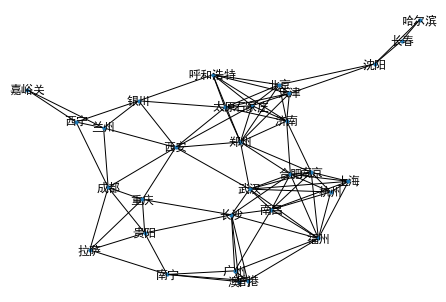

In [48]:
cities_connection_graph = nx.Graph(cities_connection)
#注意传入的参数是cities_connection_graph，city_info
nx.draw(cities_connection_graph,city_info,with_labels=True,node_size=10)

### 第四步，让我们试试在图上实现遍历算法

##### 先试试BFS吧

In [66]:
#输入包含城市路径的字典（邻接表），起点，终点，返回
#BFS的思路：使用队列先进先出。然而在python提供的数据结构中，我们可以使用列表的pop（0）和append来实现队列
def bfs(graph,start,destination):
    #注意这里pathes的数据结构是列表嵌套了列表，里一层的列表代表了已遍历路径，而不是队列里的节点
    pathes = [[start]]
    visited = set()   
    #记录一下一共遍历节点多少次
    i=0
    while pathes:
        #出列表，path是路径（列表），最终弹出的节点是froniter。pop（0）代表弹出列表首位元素
        path = pathes.pop(0)
        froniter = path[-1]
        if froniter in visited: continue
        #在邻接表中寻找frontier的后继节点    
        successsors = graph[froniter]
        for city in successsors:
            i+=1
            #避免环路的情况
            if city in path: continue 
            #注意city这是还是个字符串，[city]转为列表之后可以做列表间操作
            new_path = path+[city]
            #入队，append加到最后，pop（0）弹出首位元素等于是实现了队列的先进先出
            pathes.append(new_path)  
            #若遍历到终点，函数结束
            if city == destination:
                print('遍历%d次'%i)
                return new_path
        visited.add(froniter)
    print('不存在%s到%s的路径'%(start,destination))

In [62]:
bfs(cities_connection,"上海","哈尔滨")

遍历174次


['上海', '武汉', '郑州', '北京', '沈阳', '哈尔滨']

In [67]:
bfs(cities_connection,"上海","乌鲁木齐")

不存在上海到乌鲁木齐的路径


##### 接着是DFS

In [63]:
#输入包含城市路径的字典（邻接表），起点，终点，返回
#DFS的思路：使用栈后进先出。然而在python提供的数据结构中，我们可以使用列表的pop（0）和列表“+”运算来实现栈
def dfs(graph,start,destination):
    #注意这里pathes的数据结构是列表嵌套了列表，里一层的列表代表了已遍历路径，而不是栈里的节点
    pathes = [[start]]
    visited = set()   
    #记录一下一共遍历节点多少次
    i=0
    while pathes:
        #出列表，path是路径（列表），最终弹出的节点是froniter。pop（0）代表弹出列表首位元素
        path = pathes.pop(0)
        froniter = path[-1]
        if froniter in visited: continue
        #在邻接表中寻找frontier的后继节点    
        successsors = graph[froniter]
        for city in successsors:
            i+=1
            #避免环路的情况
            if city in path: continue 
            #注意city这是还是个字符串，[city]转为列表之后可以做列表间操作
            new_path = path+[city]
            #与bfs唯一不同的就是下面这一句，bfs是入队，dfs是入栈
            #pathes.append(new_path)  这是bfs
            #这里我们直接把new_path加到列表最前，因为pop（0）是弹出第一个元素等于是实现了栈的后进先出
            pathes=[new_path]+pathes
            #若遍历到终点，函数结束
            if city == destination:
                print('遍历%d次'%i)
                return new_path
        visited.add(froniter)
    print('不存在%s到%s的路径'%(start,destination))

In [64]:
dfs(cities_connection,"上海","哈尔滨")

遍历158次


['上海',
 '福州',
 '香港',
 '澳门',
 '南宁',
 '广州',
 '长沙',
 '重庆',
 '西安',
 '银川',
 '呼和浩特',
 '天津',
 '北京',
 '沈阳',
 '哈尔滨']

可以看到dfs没有找到最优路径（这里最优的意思是经过城市最少，因为还没有引入边的权值）

##### 现在是优化搜索的BFS（我感觉就是dijkstra）

首先我们定义计算路径长度的函数

In [68]:
def get_distance_of_path(path):
    distance = 0
    for i,_ in enumerate(path[:-1]):
        distance += get_city_distance(path[i],path[i+1])
    return distance

In [85]:
get_distance_of_path(["北京","济南","南京","上海"])

1176.03423744892

In [69]:
get_distance_of_path(["北京","济南","上海"])

1098.11914332829

In [70]:
get_distance_of_path(["北京","天津","上海"])

1069.7878955717392

In [71]:
get_distance_of_path(["北京","上海"])

1068.1567232158195

In [109]:
def bfs2(graph,start,destination,search_strategy):
    pathes = [[start]]
    #因为这里要计算最短路径，所以不能和BFS一样集合visited，否则会错过最短路径
    while pathes:
        path = pathes.pop(0)
        froniter = path[-1]
        successsors = graph[froniter]      
        for city in successsors:
            if city in path: continue            
            new_path = path+[city]           
            pathes.append(new_path)  
        #这里会对所有路径按照距离之和进行排序（根据search_strategy也可以拓展为A*等），之后优选对距离最短的路径继续遍历          
        pathes = search_strategy(pathes)
       # 下面的换成开辟一个列表记录起点到每个点的distance，应该就是dijkstra了
        if pathes and (destination == pathes[0][-1]):
            print('遍历%d次'%i)
            print('最短路径距离为%d公里'%get_distance_of_path(pathes[0]))
            return pathes[0]  

In [107]:
def sort_by_distance(pathes):
    return sorted(pathes,key=get_distance_of_path)

In [110]:
bfs2(cities_connection,"北京","上海",search_strategy=sort_by_distance)

遍历199次
最短路径距离为1176公里


['北京', '济南', '南京', '上海']

### Machine Learning 

In [89]:
from sklearn.datasets import load_boston
import random
dataset = load_boston()
x,y=dataset['data'],dataset['target']

In [90]:
x.shape

(506, 13)

In [91]:
dataset.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

我们将RM特征画到散点图上

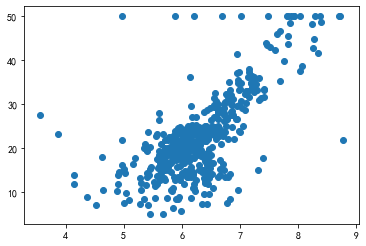

In [92]:
X_rm = x[:,5]
plt.scatter(X_rm,y)

#### Gradient descent

$$ y = k*rm + b$$

In [93]:
def price(rm, k, b):
    return k * rm + b

$$ loss = \frac{1}{n} \sum{(y_i - \hat{y_i})}^2$$

$$ loss = \frac{1}{n} \sum{(y_i - (kx_i + b_i))}^2 $$

In [94]:
def loss(y,y_hat):
    return sum((y_i - y_hat_i)**2 for y_i, y_hat_i in zip(list(y),list(y_hat)))/len(list(y))

$$ \frac{\partial{loss}}{\partial{k}} = -\frac{2}{n}\sum(y_i - \hat{y_i})x_i$$

$$ \frac{\partial{loss}}{\partial{b}} = -\frac{2}{n}\sum(y_i - \hat{y_i})$$

In [95]:
def partial_derivative_k(x, y, y_hat):
    n = len(y)
    gradient = 0
    for x_i, y_i, y_hat_i in zip(list(x),list(y),list(y_hat)):
        gradient += (y_i-y_hat_i) * x_i
    return -2/n * gradient

def partial_derivative_b(y, y_hat):
    n = len(y)
    gradient = 0
    for y_i, y_hat_i in zip(list(y),list(y_hat)):
        gradient += (y_i-y_hat_i)
    return -2 / n * gradient

In [96]:
k = random.random() * 200 - 100  # -100 100
b = random.random() * 200 - 100  # -100 100

learning_rate = 1e-3

iteration_num = 200 
#记录下losses之后可以绘图
losses = []
for i in range(iteration_num):
    
    price_use_current_parameters = [price(r, k, b) for r in X_rm]  
    
    current_loss = loss(y, price_use_current_parameters)
    losses.append(current_loss)
    print("Iteration {}, the loss is {}, parameters k is {} and b is {}".format(i,current_loss,k,b))
    
    k_gradient = partial_derivative_k(X_rm, y, price_use_current_parameters)
    b_gradient = partial_derivative_b(y, price_use_current_parameters)
    
    k = k + (-1 * k_gradient) * learning_rate
    b = b + (-1 * b_gradient) * learning_rate
best_k = k
best_b = b

Iteration 0, the loss is 572.4449902468481, parameters k is -13.28976360768523 and b is 89.26694252803676
Iteration 1, the loss is 519.2691597097011, parameters k is -13.056696429478148 and b is 89.30051686636618
Iteration 2, the loss is 474.45073810547325, parameters k is -12.842691654238767 and b is 89.3310945720135
Iteration 3, the loss is 436.6760022699012, parameters k is -12.646187031245667 and b is 89.35892123871047
Iteration 4, the loss is 404.83773666054043, parameters k is -12.465748343413463 and b is 89.38422233265216
Iteration 5, the loss is 378.0027718770358, parameters k is -12.300058914347119 and b is 89.40720484204125
Iteration 6, the loss is 355.3846258873175, parameters k is -12.147909975341456 and b is 89.42805879144451
Iteration 7, the loss is 336.32044585187526, parameters k is -12.008191821849381 and b is 89.44695863204082
Iteration 8, the loss is 320.25157452371644, parameters k is -11.879885694718245 and b is 89.46406451793197
Iteration 9, the loss is 306.707171

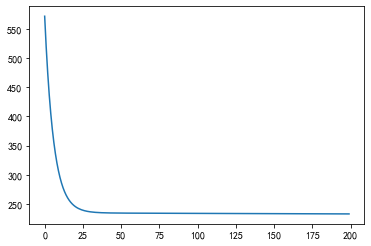

In [97]:
plt.plot(list(range(iteration_num)),losses)

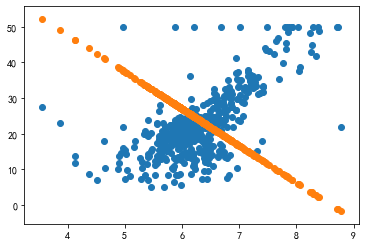

In [100]:
plt.scatter(X_rm,y)
plt.scatter(X_rm,price_use_current_parameters)

这个情况应该是上来训练走错优化的方向了（或者初始化的不太好），导致损失收敛在了232。让我们重新训练一次

In [104]:

    k = random.random() * 200 - 100  # -100 100
    b = random.random() * 200 - 100  # -100 100

    learning_rate = 1e-3

    iteration_num = 200 
    #记录下losses之后可以绘图
    losses = []
    for i in range(iteration_num):
    
        price_use_current_parameters = [price(r, k, b) for r in X_rm]  
    
        current_loss = loss(y, price_use_current_parameters)
        losses.append(current_loss)
        print("Iteration {}, the loss is {}, parameters k is {} and b is {}".format(i,current_loss,k,b))
    
        k_gradient = partial_derivative_k(X_rm, y, price_use_current_parameters)
        b_gradient = partial_derivative_b(y, price_use_current_parameters)
    
        k = k + (-1 * k_gradient) * learning_rate
        b = b + (-1 * b_gradient) * learning_rate
    best_k = k
    best_b = b

Iteration 0, the loss is 300999.87848575943, parameters k is 97.33716482996641 and b is -44.10813778099414
Iteration 1, the loss is 253692.76623247843, parameters k is 90.39886693909929 and b is -45.1983128792994
Iteration 2, the loss is 213821.98413552652, parameters k is 84.02918744509657 and b is -46.199098296378786
Iteration 3, the loss is 180218.59577248915, parameters k is 78.18152545373908 and b is -47.11781992905517
Iteration 4, the loss is 151897.41293155123, parameters k is 72.81309922854493 and b is -47.961203283193214
Iteration 5, the loss is 128028.11174386294, parameters k is 67.8846331932172 and b is -48.735422678501344
Iteration 6, the loss is 107910.88914751651, parameters k is 63.36007058568159 and b is -49.44614642077383
Iteration 7, the loss is 90955.94597639532, parameters k is 59.20630966144796 and b is -50.09857827205968
Iteration 8, the loss is 76666.19515659648, parameters k is 55.39296151632042 and b is -50.69749552216041
Iteration 9, the loss is 64622.6880472

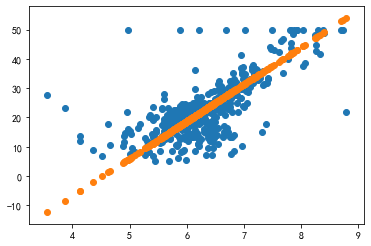

In [105]:
plt.scatter(X_rm,y)
plt.scatter(X_rm,price_use_current_parameters)

可以看出这次走上正轨了

###### 2.1 What conditions are required to make the BFS return the optimal solution ?
The value of the edges is positive.

##### 2.2 Is there a way to make DFS find the optimal solution ? (You may need to read some material about iterative DFS)
Use a  depth-limited version.Details in https://en.wikipedia.org/wiki/Iterative_deepening_depth-first_search

##### 2.3 In what conditions BFS is a better choice than DFS and vice versa ?
If the searched node is shallow reachable after some edges from the origional source, then it is better to use BFS. On the other hand, if the searched node is deep reachable after a lot of edges from the origional source, then it is better to use DFS.

##### 2.4 When can we use machine learning ?
When we have huge amounts of data,facing a data-driven task.

##### 2.5 What is the gradient of a function ?
A value,so that we can do gradient descend. 

##### 2.6 How can we find the maximum value of a function using the information of gradient ?
Do the gradient ascend to make the value of the function converge.